In [107]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
 
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
 
from os.path import join as pjoin
import glob
import numpy as np
from numpy import hstack as stack
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.stattools import acf

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [108]:
# Retail sales of beer, wine and liquor in the U.S.
# Monthly data from January 1992 till November 2017
BeerWine = pd.read_csv('data/BeerWineUS.csv', header=0, index_col=0,
                       squeeze=True)

# Real (inﬂation corrected) interest rate for bank deposits with
# investment durations between one and two years
interestrate = pd.read_csv('data/interestrate.csv', sep=';',
                           index_col=0, header=None).iloc[:,0]
interestrate = interestrate.map(lambda s: float(s.replace(',', '.')))

# Crude oil price per barrel
CrudeOil = pd.read_csv('data/CrudeOil.csv', header=0, index_col=0, squeeze=True)

#### ARMA modelling with `interestrate.csv`. Keep the last year for forecasting.

178: 177 + 1


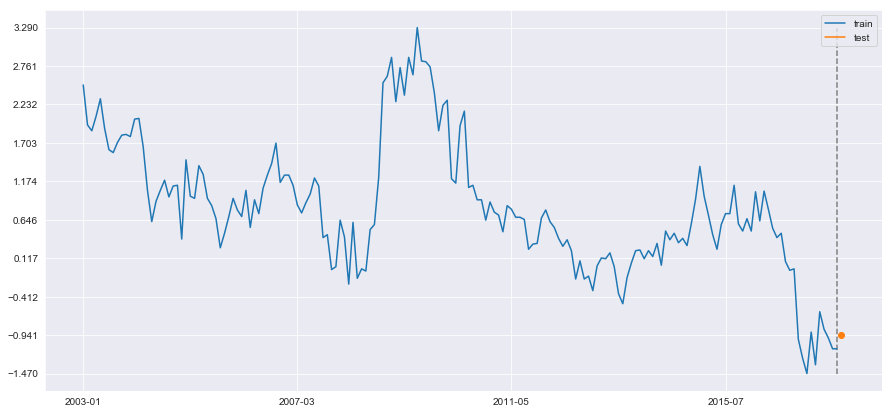

In [109]:
mpl.rcParams['figure.figsize'] = (15,7)

N = len(interestrate)
n_train = N-1
train, test, n_test = split_ts(interestrate, n_train)

(a) Check the ACF and decide about the strength of the memory in the time series using Box-Ljung/Pierce tests.

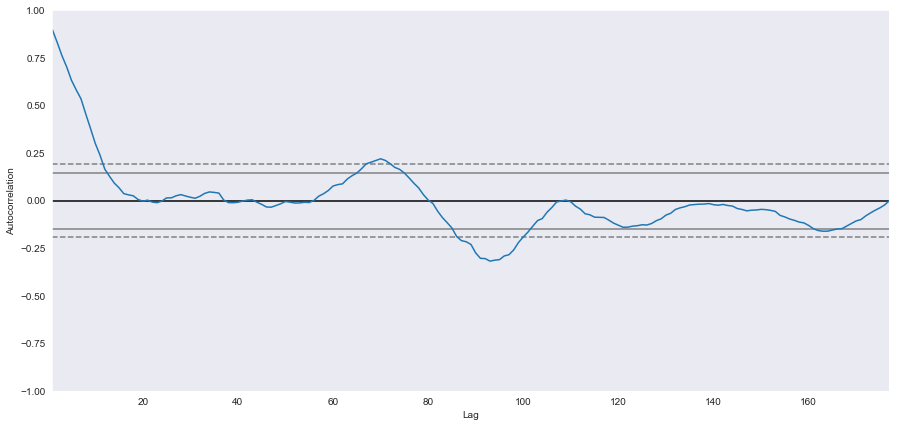

Box-Ljung test:


array([2.45420971e-033, 2.66995414e-059, 4.91326254e-081, 1.88801804e-099,
       2.84784824e-114, 9.58496923e-127, 3.35105329e-137, 1.43500278e-144,
       2.05461322e-149, 3.97769468e-152, 1.63937080e-153, 1.03741757e-153,
       1.79684957e-153, 6.25500711e-153, 3.05068073e-152, 1.94634032e-151,
       1.25144391e-150, 8.00851728e-150, 5.26986354e-149, 3.37861181e-148,
       2.11157342e-147, 1.27892089e-146, 7.51908731e-146, 4.37296402e-145,
       2.44272886e-144, 1.33531656e-143, 6.85311019e-143, 3.32637635e-142,
       1.65248870e-141, 8.29243467e-141, 4.15484780e-140, 1.97173387e-139,
       8.37549129e-139, 3.26688253e-138, 1.28358263e-137, 5.12682000e-137,
       2.37749620e-136, 1.07490894e-135, 4.78534296e-135, 2.11359374e-134,
       9.29370650e-134, 4.03707361e-133, 1.73012873e-132, 7.27413694e-132,
       2.91295119e-131, 1.05966857e-130, 3.77838846e-130, 1.41606063e-129,
       5.50004179e-129, 2.17897473e-128, 8.49323432e-128, 3.23991253e-127,
       1.22656903e-126, 4

In [110]:
from pandas.plotting import autocorrelation_plot

# ACF(train)
autocorrelation_plot(train)
plt.show()
print('Box-Ljung test:')
_, qstat, pvalue = acf(train, nlags=len(train)//2, qstat=True)
qstat
pvalue

(b) Try `MA(1)`, `AR(1)` and `ARMA(1,1)` processes and check the ﬁt (ACF of residuals, AIC, etc.)


MA(1):
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                     ARMA(0, 1)   Log Likelihood                -163.730
Method:                       css-mle   S.D. of innovations              0.609
Date:                Tue, 12 Feb 2019   AIC                            333.459
Time:                        11:54:59   BIC                            342.988
Sample:                             0   HQIC                           337.323
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8134      0.078     10.404      0.000       0.660       0.967
ma.L1.y        0.7118      0.042     17.087      0.000       0.630       0.793
                                    Roots   

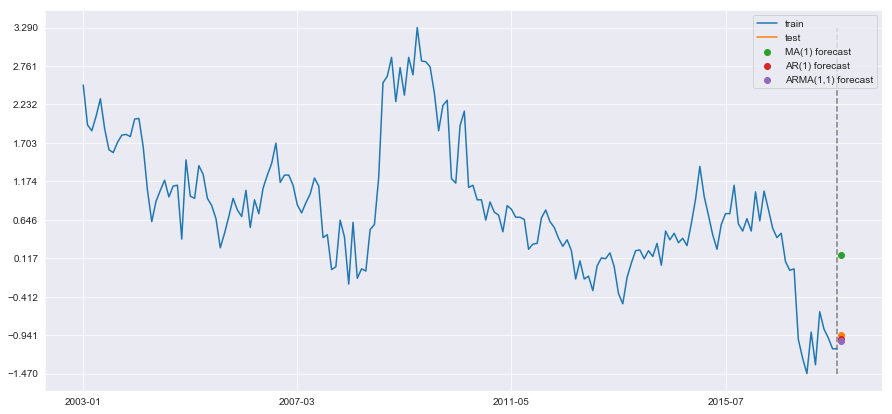

In [111]:
from statsmodels.tsa.arima_model import ARIMA
# import pyflux as pf
# model = pf.ARIMA(pd.DataFrame(train),0,1)
# model.fit('MLE').summary()
show_series(train, test)

model_name = 'MA(1)'
print('\n{}:'.format(model_name))
model = ARIMA(np.array(train), order=(0,0,1)).fit()
print(model.summary())
forecast, _, _ = model.forecast(1)
plt.scatter(test.index, forecast, label='{} forecast'.format(model_name), color='C2')

model_name = 'AR(1)'
print('\n{}:'.format(model_name))
model = ARIMA(np.array(train), order=(1,0,0)).fit()
print(model.summary())
forecast, _, _ = model.forecast(1)
plt.scatter(test.index, forecast, label='{} forecast'.format(model_name), color='C3')

model_name = 'ARMA(1,1)'
print('\n{}:'.format(model_name))
model = ARIMA(np.array(train), order=(1,0,1)).fit()
print(model.summary())
forecast, _, _ = model.forecast(1)
plt.scatter(test.index, forecast, label='{} forecast'.format(model_name), color='C4')

plt.legend()
plt.show()

(c) Try diﬀerencing and subsequent application of MA(1), AR(1) and ARMA(1,1). Check again the processes and check the ﬁt (signiﬁcance, ACF, AIC, etc.) Decide which model is the best one.

(d) Try autoarima (in R) and compare the ﬁnal model with the one you found in the previous step.

In [112]:
%%R -i train -i test
library('forecast')
library('tseries')

auto.arima(train)

Series: train 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.1955
s.e.   0.0742

sigma^2 estimated as 0.1261:  log likelihood=-67.01
AIC=138.02   AICc=138.09   BIC=144.36


(e) Compute the forecasts and forecast intervals using the ﬁnal model.

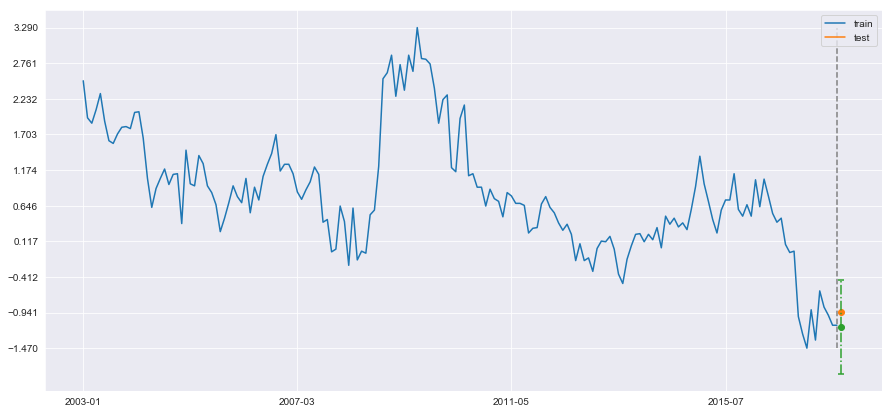

In [113]:
show_series(train, test)
model = ARIMA(np.array(train), order=(1,1,0)).fit()
alpha = 0.05
forecast, stderr, conf_int = model.forecast(1, alpha=alpha)
plt.scatter(test.index, forecast, label='{} forecast'.format(model_name), color='C2')
plt.vlines(test.index, *conf_int[0], 'C2', '-.')
plt.scatter(test.index, conf_int[:,0], color='C2', marker='_')
plt.scatter(test.index, conf_int[:,1], color='C2', marker='_')

(f) Explain why multi-step-ahead forecasts have wider forecast intervals than onestep-ahead-forecasts.

(g) Imagine an ACF with only the ﬁrst two correlations being signiﬁcant. Which process is suitable to model this and why?

(h) Imagine an ACF which consists only of positive values and quickly decays towards zero. Which process is suitable to model this and why?

(i) Consider an AR(1) process with parameter α 1 . Assume we have a shock to a time series (a large error term, unexpected event) at the time point t = 10. Which impact do you expect this shock to have on the observation at time point t = 15? Provide the formula and give formal motivation.